Este programa utiliza comandos SQL para obtener datos de exoplanets.eu, luego hace una comparación entre algunas técnicas

------------

Un analisis previo consistió en traer todas las columnas y buscar las que necesitaba. Para eso limité el período a que sea menor a 3 dias (arbitrario). Ese análisis no lo dejo explícito, sólo esta línea comentándolo.
El query era: query = "SELECT * FROM exoplanet.epn_core WHERE period<3"

Luego hice un query ya trayendo las columnas que necesito y también limitando un poco los datos (periodos no negativos, masas menores a ~15 Mjup, etc

Depués separé los datos por técnica y los grafique. Por último hice una comparación simple de las técnicas para ver si existe un sesgo en la media de las masas y período

In [1]:
%matplotlib inline 
import numpy as np 
import matplotlib.pyplot as plt
import pyvo
# Estilo de gráficos
plt.style.use('dark_background')
# Servicio pyvo
service = pyvo.dal.TAPService("http://voparis-tap-planeto.obspm.fr/tap")

In /home/matt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/matt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/matt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/matt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/matt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-d

Consideraré planetas y no enanas marrones => mass < ~15Mjup y filtraré los periodos para que no sean negativos

In [2]:
query = """SELECT period, mass, star_spec_type, detection_type
FROM exoplanet.epn_core
WHERE mass<15 AND period>0 AND star_distance>0"""

In [3]:
res = service.search(query);

In [4]:
# Veo el primer planeta de los resultados
res.table[:2]

period,mass,star_spec_type,detection_type
d,'jupiterMass',,
float64,float64,object,object
10260.0,2.6,F0IV,Imaging
4.2308,0.47,G2 IV,Radial Velocity


In [5]:
# Obtengo los valores de las columnas en listas con un loop
size = np.shape(res) # size[0] es la cantidad de exoplanetas que tengo
P = [] # Períodos
Mass = [] # Masas
Spec = [] # Tipo espectral
Tec = [] # Técnica de detección

ij = 0
while ij < size[0]:
    P.append( res.getvalue(name='period', index=ij) )
    Mass.append( res.getvalue(name='mass', index=ij) )
    Spec.append( res.getvalue(name='star_spec_type', index=ij) )
    Tec.append( res.getvalue(name='detection_type', index=ij) )
    ij = ij + 1

Para simplicidad sólo consideraré algunas técnicas y no todas, armo listas con las posiciones de los planetas en función de la técnica y luego uso la función Clasif() para clasificarlos:

In [6]:
VR = []
Tran = []
TTV = []
Pulsar = []
ij = 0
while ij<size[0]:
    if Tec[ij] == 'Radial Velocity': # CUIDADO, aveces se usa : b'Radial Velocity'
        VR.append(ij)                # Hay que chequear con np.unique(Tec)
    if Tec[ij] == 'Primary Transit':
        Tran.append(ij)
    if Tec[ij] == 'TTV':
        TTV.append(ij)
    if Tec[ij] == 'Pulsar':
        Pulsar.append(ij)
    ij = ij + 1

In [7]:
def Clasif(X):
    """ Devuelve el periodo y masa para los planetas en función de su técnica de detección
    
    Parameters
    ----------
    X : list
        Lista con valores enteros que localizan a la técnica asociada al arreglo X. 
        Por ej: X:VR tendrá los valores para las posiciones de todos los planetas que fueron
        detectados por esa técnica. Si tengo 3 planetas y los dos últimos fueron detectados
        por VR => X = [1,2] ( NO es X=[0,1,2] )
        
    Returns
    -------
    Per, Masa : list, list
        Listas con los parámetros asociados a la técnica requerida
        
    """
    Per = []
    Masa = []
    for ij in X:
        Per.append(P[ij])
        Masa.append(Mass[ij])
    return (Per, Masa)

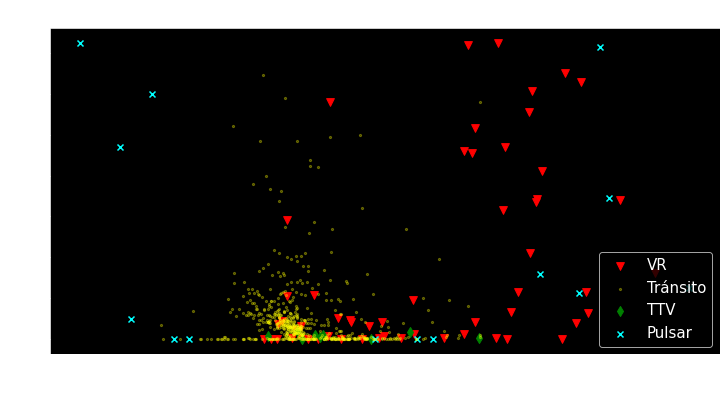

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (12,6))

ax.scatter(Clasif(VR)[0], Clasif(VR)[1], color='red', zorder=0, marker='v', s=60,
          label='VR')
ax.scatter(Clasif(Tran)[0], Clasif(Tran)[1], color='yellow', zorder=10, alpha=0.3, s=5,
          label='Tránsito')
ax.scatter(Clasif(TTV)[0], Clasif(TTV)[1], color='green', marker='d', s=50,
          label='TTV')
ax.scatter(Clasif(Pulsar)[0], Clasif(Pulsar)[1], color='cyan', marker='x',
          label='Pulsar')

ax.set_xscale('log')
ax.set_title('Masa vs periodo', fontsize=20)
ax.set_ylabel('Masa [MJup]', fontsize=20)
ax.set_xlabel('Periodo [d]', fontsize=20);
ax.legend(fontsize=15, loc=4);

Comparación de técnicas.

---------

Como las distribuciones de masa y período para c/u de las técnicas no son gaussianas, no se me ocurre cómo calcular un intervalo de confianza para hacer una prueba de hipótesis. Entonces hago un análisis simple de intervalos para ello. 

Osea que el $\color{cyan}{\text{criterio}}$ es que si los intervalos se superponen --> las técnicas son indistinguibles

In [9]:
# MASAS
M = [Clasif(VR)[1], Clasif(Tran)[1], Clasif(TTV)[1], Clasif(Pulsar)[1]] # Lista auxiliar 
Medias = [np.mean(M[0]), np.mean(M[1]), np.mean(M[2]), np.mean(M[3])]
Desv = [np.std(M[0]), np.std(M[1]), np.std(M[2]), np.std(M[3])]
# Una vez tengo las medias y sus incertezas, creo los rangos para compararlos
Rangos = []
ij = 0
while ij<len(M):
    Rangos.append([Medias[ij] - Desv[ij], Medias[ij] + Desv[ij]])
    ij = ij + 1
    
# PERIODOS
Pers = [Clasif(VR)[0], Clasif(Tran)[0], Clasif(TTV)[0], Clasif(Pulsar)[0]] 
Medias2 = [np.mean(Pers[0]), np.mean(Pers[1]), np.mean(Pers[2]), np.mean(Pers[3])]
Desv2 = [np.std(Pers[0]), np.std(Pers[1]), np.std(Pers[2]), np.std(Pers[3])]

Rangos2 = []
ij = 0
while ij<len(M):
    Rangos2.append([Medias2[ij] - Desv2[ij], Medias2[ij] + Desv2[ij]])
    ij = ij + 1

Veo la lista de rangos para las masas:

In [10]:
Rangos

[[-1.0127662376329698, 8.00089114991367],
 [-0.6669350204892988, 2.776251752921039],
 [0.030681463509787565, 0.2924252031568791],
 [-0.6576022397550396, 10.103109382612182]]

Cualitativamente se ve que todas las técnicas son compatibles (había hecho un gráfico -tipo histograma- para ver pero quedó bastante mal y creo que, como son pocos datos, con observarlos basta para sacar conclusiones (dado el criterio), no hay sesgo en la comparación de masa, veo la comparación de períodos:

In [11]:
Rangos2

[[-1509.6599342948612, 3343.0344932001244],
 [-17.196439644933548, 39.51750217619976],
 [-42.3861522841662, 130.45417072861065],
 [-5657.047484488734, 12945.037841307663]]

Acá tampoco se ven incompatibilidades, a pesar de que se notan los rangos distintos, la dispersión de las técnicas las llevan a los valores negativos y todas son compatibles (ésto es un un artefacto de la creación del rango con la desviación estándar)

------------

Entonces, a pesar de los biases de las técnicas, el hecho de que no hay suficientes datos como para reducir lo suficiente la dispersión hace que las técnicas sean indistingibles -bajo mi criterio-